# From automatic to manual

In the [previous example](/feedbax/examples/0_train_simple), almost everything was pre-built and we didn't get to see how the model was put together. Let's rebuild the same model, but more explicitly.

First, we'll explicitly define the values of some parameters, where last time we had just implicitly accepted the default values defined in the pre-built model/task.

In [1]:
mass = 1.0  # Mass of the point mass
n_steps = 100  # Number of time steps per trial
dt = 0.05  # Duration of a time step
feedback_delay_steps = 0  # Number of time steps to delay the feedback
feedback_noise_std = 0.1  # Standard deviation of Gaussian noise added to sensory feedback
workspace = ((-1., -1.),  # Workspace bounds ((x_min, y_min), (x_max, y_max)
             (1., 1.))
hidden_size  = 50  # Number of units in the hidden layer of the neural network

Now, we'll use `jax.random.split` to get several random keys we can use for different purposes as we go along.

In [2]:
import jax.random as jr

seed = 0
key = jr.PRNGKey(seed)  # This is the parent key

# Split into three different keys for initialisation, training, and evaluation
key_init, key_train, key_eval = jr.split(key, 3)

## Pairing of a pre-built model with a different task

Last time we saw that `feedbax.xabdeef` provides some pre-built pairings of tasks and models, which can be constructed with a single line of code, then trained immediately.

However, it also provides pre-built models that aren't paired with tasks. For example, we can import `point_mass_nn` and use it to construct the same model as `point_mass_nn_simple_reaches` did—but just the model.

We'll use the same task as before, but construct it explicitly: `SimpleReaches` combined with the pre-built loss function `simple_reach_loss`. 

!!! Warning ""    
    We have to construct the task before the model, since the structure of the model—the number of inputs to the neural network—depends on the kind of information the task will send it—in this case, the goal it should currently be reaching for.

In [3]:
from feedbax.task import SimpleReaches

from feedbax.xabdeef.losses import simple_reach_loss
from feedbax.xabdeef.models import point_mass_nn


task = SimpleReaches(
    loss_func=simple_reach_loss(),
    workspace=workspace,
    n_steps=n_steps,
)

model = point_mass_nn(
    task,
    dt=dt,
    mass=mass,
    hidden_size=hidden_size,
    n_steps=n_steps,
    feedback_delay_steps=feedback_delay_steps,
    feedback_noise_std=feedback_noise_std,
    key=key_init,
)

At this point we could construct a `TaskTrainer` and use it to train the model on the task, but let's go just one level deeper first and define exactly the same model without using a pre-built function from `feedbax.xabdeef`.

## Building the model ourselves using core Feedbax

Let's rewrite the function `point_mass_nn` right here, and see how it's built out of Feedbax components. First we'll show the whole thing, and then we'll go through it step-by-step.

In [4]:
from feedbax.bodies import SimpleFeedback
from feedbax.iterate import Iterator
from feedbax.mechanics.mechanics import Mechanics
from feedbax.mechanics.plant import DirectForceInput
from feedbax.mechanics.skeleton.pointmass import PointMass
from feedbax.nn import SimpleStagedNetwork


def get_model(
    task,
    dt: float = 0.05,
    mass: float = 1.,
    hidden_size: int = 50,
    n_steps: int = 100,
    feedback_delay: int = 0,
    feedback_noise_std: float = 0.0,
    *,  # This asterisk forces us to pass `key` as a keyword argument
    key,
):
    key1, key2 = jr.split(key)  # 1

    plant = DirectForceInput(PointMass(mass=mass))  # 2
    mechanics = Mechanics(plant, dt)  # 3

    feedback_spec = dict(  # 4
        where=lambda state: (
            state.effector.pos,
            state.effector.vel,
        ),
        delay=feedback_delay,
        noise_std=feedback_noise_std,
    )

    # Determine the network input size automatically
    input_size = SimpleFeedback.get_nn_input_size(  # 5
        task, mechanics, feedback_spec
    )

    net = SimpleStagedNetwork(  # 6
        input_size,
        hidden_size,
        out_size=plant.input_size,
        key=key1
    )

    body = SimpleFeedback(net, mechanics, feedback_spec=feedback_spec, key=key2)  # 7

    model = Iterator(body, n_steps)  # 8

    return model

What's happening here?

1. We only pass a single key to the function. The function needs two keys though, which it splits for itself.
2. Our biomechanical model—or *plant*—is a point mass. We'll move it by directly applying force. In more complex models, the input to the mechanical model can be signals to [simulated muscles](/feedbax/examples/biomechanics), in which case the forces aren't supplied directly, but produced by the muscles contracting.
3. Our plant model describes *continuous* dynamics. We need to discretize it, and associate it with a numerical solver of differential equations. We do this by wrapping it in `Mechanics`, with a value for the time step duration.
4. Define which parts of the mechanical state will be available to the neural network as sensory feedback. The function `where`, when passed the `state` associated with `mechanics`, will return the parts of that state we want to be part of the feedback. In the case of a point mass, we use the position and velocity of the point mass itself. Feedback may be noisy or delayed, and we also define values for those parameters at this point.
5. Figure out how many inputs the neural network will need. This depends on the information that the task will provide to the network, but also the kind of sensory feedback. The method `get_nn_input_size` figures this out for us.
6. Construct our neural network model.
7. Construct a model in which our neural network sends commands to our mechanical model, and gets feedback in return.
8. All of the preceding steps define a single time step of the model. We wrap this into an object that loops the model for a given number of timesteps.

Using our function, we can now construct a model just like we did with `point_mass_nn`:

In [5]:
model = get_model(
    task,
    dt=dt,
    hidden_size=hidden_size,
    n_steps=n_steps,
    feedback_delay=feedback_delay_steps,
    feedback_noise_std=feedback_noise_std,
    key=key_init,
)

### Examining the model's tree structure

Now's a good time to take a look at the structure of the model we've built. Since all Feedbax models are [Equinox](/feedbax/examples/pytrees#equinox) modules, we can simply print them and the output is a nice tree.

In [6]:
model

Iterator(
  _step=SimpleFeedback(
    net=SimpleStagedNetwork(
      hidden=GRUCell(
        weight_ih=f32[150,8],
        weight_hh=f32[150,50],
        bias=f32[150],
        bias_n=f32[50],
        input_size=8,
        hidden_size=50,
        use_bias=True
      ),
      hidden_size=50,
      hidden_noise_std=None,
      hidden_nonlinearity=<function identity_func>,
      out_size=2,
      out_nonlinearity=<function identity_func>,
      readout=Linear(
        weight=f32[2,50],
        bias=f32[2],
        in_features=50,
        out_features=2,
        use_bias=True
      ),
      encoding_size=None,
      encoder=None,
      intervenors={
        'hidden':
        [],
        'hidden_nonlinearity':
        [],
        'readout':
        [],
        'out_nonlinearity':
        []
      }
    ),
    mechanics=Mechanics(
      plant=DirectForceInput(
        skeleton=PointMass(mass=1.0),
        clip_states=True,
        intervenors={'clip_skeleton_state': []}
      ),
      dt=0.0

!!! Note ""
    The notation `f32[150,8]` indicates a JAX array of shape `(150, 8)` filled with `float32` values.

This tree reflects how we defined our model. We can see that:

- The topmost level is an `Iterator`, which is responsible for looping over a model step for `n_steps`.
- The model step is an instance of `SimpleFeedback`, composed of a `SimpleStagedNetwork` which sends commands to, and receives feedback from, a `Mechanics` instance
- The `Mechanics` instance contains a plant `DirectForceInput` which wraps a `PointMass` "skeleton".

**Importantly, the tree does not show us *how* each part of the model performs its computations, including how it calls its components.** This representation only shows us which parts of the model *contain* which other parts or parameters.

??? Note "Even more info about the tree"

    The tree also shows several things that were not explicit in the way we defined our model earlier:

    - `SimpleStagedNetwork` consists of a `GRUCell` containing arrays of weights, as well as a `Linear` readout with its own weights. However, `encoder=None` since by default the network object is constructed without a separate layer for encoding its inputs. All of these aspects can be controlled by different arguments we could have passed to `SimpleStagedNetwork`.
    - `Mechanics` is using the default `Euler` solver. Usually this is sufficient, but in some cases it might be more accurate to use one of the higher-order solvers provided by `diffrax`, by passing it as the `solver` argument when wrapping our plant in `Mechanics`.
    - Part of the tree is called `channels`, and contains a single `Channel` in it. This channel was constructed by `SimpleFeedback`, based on the `feedback_spec` we passed it. It's easy to [ask](/feedbax/examples/1_train#a-different-model) for multiple feedback channels with different delays and noise. 
    - Each inner level of the model has a dictionary `intervenors` which contains a bunch of empty lists. Interventions are a powerful feature of Feedbax that we'll check out in the next example. 

## Training the model

We need to construct a `TaskTrainer`. In the first example this [was managed](/feedbax/examples/0_train_simple/#training-the-model) for us automatically. 

We can explicitly tell the trainer to use the Adam optimizer, or any other optimizer [provided by Optax](https://optax.readthedocs.io/en/latest/api/optimizers.html).

In [7]:
import optax

from feedbax.train import TaskTrainer


trainer = TaskTrainer(
    optimizer=optax.adam(learning_rate=1e-2)
)

Now we can train our model to perform the task. 

### Selecting part of the model to train

We'll be explicit about which part of the model we want to train:

- All the arrays inside the `GRUCell` layer, which is located at `model.step.net.hidden`, as seen in the printout of the model from earlier;
- All the arrays inside of the `Linear` readout layer at `model.step.net.readout`. 

We write a `lambda` function that the trainer will use to pick out these parts of the model. This is similar to how we wrote a function to pick out the parts of the state to send as sensory feedback.

In [8]:
where_train = lambda model: (
    model.step.net.hidden,
    model.step.net.readout,
)

# Train the model on the task!
model, train_history = trainer(
    task=task,
    model=model,
    n_batches=2000,
    batch_size=250,
    log_step=200,  # Print out the loss every 200 batches
    where_train=where_train,
    key=key_train,
)

Training step compiled in 2.37 seconds.
Validation step compiled in 2.18 seconds.


train batch:   0%|          | 0/2000 [00:00<?, ?it/s]


Training iteration: 0
	training loss: 3.01e+01
	validation loss: 6.41e+00

Training iteration: 200
	training loss: 3.08e-02
	validation loss: 2.99e-02

Training iteration: 400
	training loss: 2.65e-02
	validation loss: 1.75e-02

Training iteration: 600
	training loss: 2.73e-02
	validation loss: 1.20e-02

Training iteration: 800
	training loss: 2.65e-02
	validation loss: 2.48e-02

Training iteration: 1000
	training loss: 2.51e-02
	validation loss: 2.74e-02

Training iteration: 1200
	training loss: 2.53e-02
	validation loss: 2.82e-02

Training iteration: 1400
	training loss: 2.33e-02
	validation loss: 2.03e-02

Training iteration: 1600
	training loss: 2.47e-02
	validation loss: 1.51e-02

Training iteration: 1800
	training loss: 2.19e-02
	validation loss: 1.92e-02

Training iteration: 1999
	training loss: 2.23e-02
	validation loss: 2.12e-02

Completed training run on a total of 500,000 trials.


Actually, examining the model tree reveals that `model.step.net.hidden` and `model.step.net.readout` contain all of the JAX arrays inside of `model.step.net` that could even be trained in this case. So we could have written:

In [9]:
where_train = lambda model: model.step.net

and nothing would have changed. Since Feedbax is based on JAX/Equinox, we're pretty flexible in how we can specify parts of models or states.

Use of `lambda` is common in Feedbax. Remember that `lambda` is merely a convenient way of defining a function in-line. It would also would have made no difference if we had written:

In [10]:
def where_train(model):
    return model.step.net

### Evaluating the trained model, and examining states

The model can be evaluated [as before](feedbax/examples/0_train_simple/#evaluating-the-trained-model). 

In [11]:
states = task.eval(model, key=key_eval)

Similarly to the model itself, the PyTree of states is also an Equinox module and has a nice representation:

In [12]:
states

SimpleFeedbackState(
  mechanics=MechanicsState(
    plant=PlantState(
      skeleton=CartesianState(
        pos=f32[7,100,2],
        vel=f32[7,100,2],
        force=f32[7,100,2]
      ),
      muscles=None
    ),
    effector=CartesianState(
      pos=f32[7,100,2],
      vel=f32[7,100,2],
      force=f32[7,100,2]
    ),
    solver=None
  ),
  net=NetworkState(hidden=f32[7,100,50], output=f32[7,100,2], encoding=None),
  feedback=ChannelState(
    output=(f32[7,100,2], f32[7,100,2]),
    queue=((f32[7,100,2], f32[7,100,2]),),
    noise=(f32[7,100,2], f32[7,100,2])
  )
)

This tree does not show us *how* each part of the state was computed. It only shows us the overall structure of the data that was operated on by the model. 

Of course, there is some overlap between the [structure of `model`](feedbax/examples/1_train/#examining-the-models-tree-structure) and that of `states`, because certain components in the model depend on certain parts of the state being included. For example, `Mechanics` expects to be a passed a `MechanicsState` object to work on, and (looking at the state tree) this object can be found inside the `SimpleFeedbackState` object, similarly to how `Mechanics` is a component of `SimpleFeedback`.

## A different task

We can train the same type of model on a different task. We'll start by generating a new instance of the model using the same `get_model` function we already wrote, using the same hyperparameters as before, but for a delayed reaching task. 

In [13]:
from feedbax.task import DelayedReaches
from feedbax.xabdeef.losses import delayed_reach_loss

task_delayed = DelayedReaches(
    loss_func=delayed_reach_loss(),
    workspace=workspace,
    n_steps=n_steps,
)

model = get_model(
    task_delayed,
    dt=dt,
    hidden_size=hidden_size,
    n_steps=n_steps,
    feedback_delay=feedback_delay_steps,
    feedback_noise_std=feedback_noise_std,
    key=key_init,
)

`DelayedReaches` is similar to `SimpleReaches` except that on each trial, the information about the reach target is only presented to the network for a limited time, after which the network must continue to wait to begin the reach until a *hold signal* has been switched off. Likewise, the loss function `delayed_reach_loss` has one additional term, which penalizes the model for moving away from the starting position before the release of the hold signal.

The only difference in the model itself is that its neural network has been constructed with additional input features for the hold signal, and for one additional "target ON" signal that tells the network when it is being shown the target.

Now train the model for 10,000 iterations, and evaluate the trained model on the task.

In [14]:
where_train = lambda model: (
    model.step.net.hidden,
    model.step.net.readout,
)

model, train_history = trainer(
    task=task_delayed,
    model=model,
    n_batches=10_000,
    batch_size=250,
    log_step=500,  # Print out the loss every 200 batches
    where_train=where_train,
    key=key_train,
)

states = task_delayed.eval(model, key=key_eval)

Training step compiled in 2.32 seconds.
Validation step compiled in 1.86 seconds.


train batch:   0%|          | 0/10000 [00:00<?, ?it/s]


Training iteration: 0
	training loss: 2.81e+01
	validation loss: 1.60e+01

Training iteration: 500
	training loss: 3.33e-01
	validation loss: 1.40e-01

Training iteration: 1000
	training loss: 2.23e-01
	validation loss: 7.49e-02

Training iteration: 1500
	training loss: 2.12e-01
	validation loss: 7.73e-02

Training iteration: 2000
	training loss: 2.05e-01
	validation loss: 8.88e-02

Training iteration: 2500
	training loss: 1.93e-01
	validation loss: 8.74e-02

Training iteration: 3000
	training loss: 2.04e-01
	validation loss: 5.54e-02

Training iteration: 3500
	training loss: 1.91e-01
	validation loss: 5.94e-02

Training iteration: 4000
	training loss: 1.65e-01
	validation loss: 6.53e-02

Training iteration: 4500
	training loss: 2.11e-01
	validation loss: 6.30e-02

Training iteration: 5000
	training loss: 1.53e-01
	validation loss: 5.83e-02

Training iteration: 5500
	training loss: 1.83e-01
	validation loss: 5.72e-02

Training iteration: 6000
	training loss: 1.63e-01
	validation loss:

The loss history is a little different than [what we saw](feedbax/examples/0_train_simple/#interpreting-the-training-history) for simple reaches: at some points duing training, the *fixation* term that penalizes movements made during the hold signal was just as important as the effector position term.

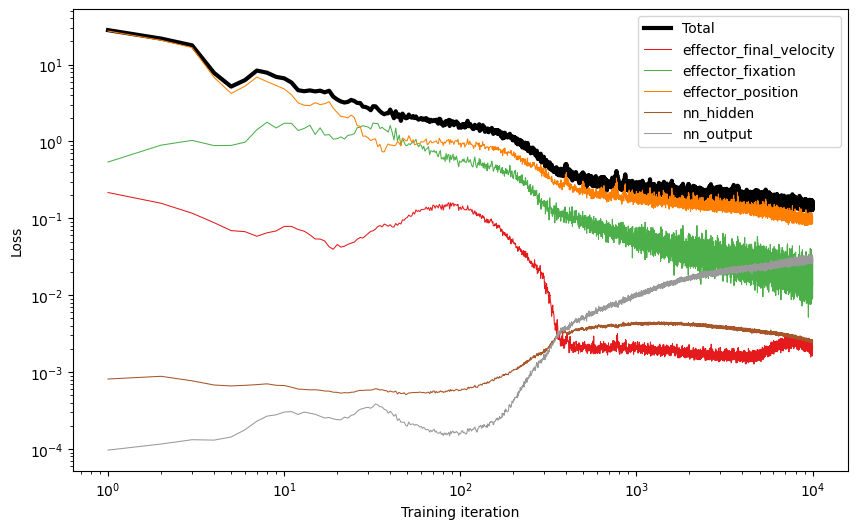

In [19]:
from feedbax.plot import plot_loss_history

_ = plot_loss_history(train_history)

Finally, let's visualize whether the network really waited to start moving until the hold signal was released.

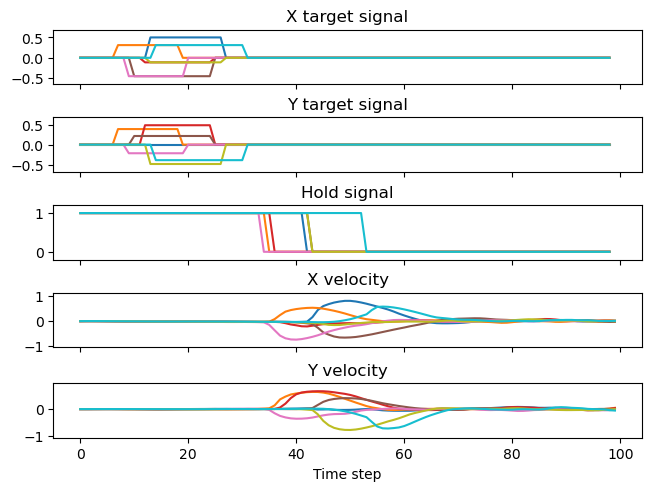

In [36]:
from feedbax.plot import plot_task_profiles

trial_specs = task_delayed.validation_trials
# assume the goal is the target state at the last time step
_ = plot_task_profiles({
        'X target signal': trial_specs.inputs.effector_target.pos[..., 0],
        'Y target signal': trial_specs.inputs.effector_target.pos[..., 1],
        'Hold signal': trial_specs.inputs.hold,
        'X velocity': states.mechanics.effector.vel[..., 0],
        'Y velocity': states.mechanics.effector.vel[..., 1],
})

The bottom two subplots show the $x$ and $y$ velocity of the point mass over the validation trials. Comparing these to the target signals, it appears the point mass moves in the right direction on each trial. It also appears that the point mass only moves once the hold signal for the trial is released, but we can visualize this a little better:

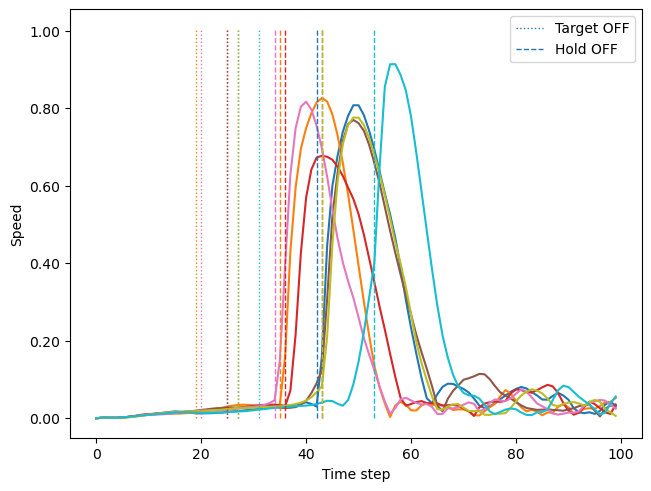

In [52]:
from feedbax.plot import plot_speed_profiles

_ = plot_speed_profiles(states.mechanics.effector.vel, trial_specs.epoch_start_idxs)

Actually, the network is anticipating the release of the hold signal, especially when the delay is longer! This means the cost function or task trials need to be adjusted.    

## A different model

What if we want to build a model where the network controls an arm with two rotational joints (think: double pendulum) by directly applying torques, instead of controlling a point mass by directly applying forces?

Unlike with the point mass, in this case there's a difference between 

1. the state of the effector—the end of the arm, which is the part that needs to reach the target;
2. the intrinsic state of the arm—its joint angles and angular velocities.

We want to treat these as two kinds of feedback: the joint information as fast "proprioceptive" feedback, and knowledge of the location of the end of the arm as slower "visual" feedback.

In [49]:
from feedbax.mechanics.skeleton.arm import TwoLinkArm


def get_model(
    task,
    key=None,
    dt=0.05,
    hidden_size=50,
    n_steps=50,
    proprioception_delay=3,
    vision_delay=5,
):
    if key is None:
        # in case we just want a skeleton model, e.g. for deserializing
        key = jr.PRNGKey(0)

    key1, key2, key3 = jr.split(key, 3)

    plant = DirectForceInput(TwoLinkArm())  # 1
    mechanics = Mechanics(plant, dt)

    feedback_spec = dict(  # 2
        proprioception=dict(  # We can label this however we like.
            where=lambda state: (
                state.plant.skeleton.angle,  # joint angles
                state.plant.skeleton.d_angle,  # angular velocities
            ),
            delay=proprioception_delay,
            noise_std=feedback_noise_std,
        ),
        vision=dict(
            where=lambda state: (
                state.effector.pos,  # position of the end of the arm
                state.effector.vel,  # velocity of the end of the arm
            ),
            delay=vision_delay,
            noise_std=feedback_noise_std,
        )
    )

    input_size = SimpleFeedback.get_nn_input_size(
        task, mechanics, feedback_spec
    )

    net = SimpleStagedNetwork(
        input_size,
        hidden_size,
        out_size=mechanics.plant.input_size,
        key=key1,
    )

    body = SimpleFeedback(
        net,
        mechanics,
        feedback_spec=feedback_spec,
        key=key3,
    )

    return Iterator(body, n_steps)

Only a couple of things are different here:

1. Our plant is now based on a two-link arm model `TwoLinkArm`, which is directly controlled by torques, rather than a `PointMass` which was directly controlled by linear forces.
2. We now specify two different feedback channels with different delays

What does the structure of this model look like?

In [50]:
model = get_model(task, key=key_init)

model

Iterator(
  _step=SimpleFeedback(
    net=SimpleStagedNetwork(
      hidden=GRUCell(
        weight_ih=f32[150,12],
        weight_hh=f32[150,50],
        bias=f32[150],
        bias_n=f32[50],
        input_size=12,
        hidden_size=50,
        use_bias=True
      ),
      hidden_size=50,
      hidden_noise_std=None,
      hidden_nonlinearity=<function identity_func>,
      out_size=2,
      out_nonlinearity=<function identity_func>,
      readout=Linear(
        weight=f32[2,50],
        bias=f32[2],
        in_features=50,
        out_features=2,
        use_bias=True
      ),
      encoding_size=None,
      encoder=None,
      intervenors={
        'hidden':
        [],
        'hidden_nonlinearity':
        [],
        'readout':
        [],
        'out_nonlinearity':
        []
      }
    ),
    mechanics=Mechanics(
      plant=DirectForceInput(
        skeleton=TwoLinkArm(
          l=f32[2],
          m=f32[2],
          I=f32[2],
          s=f32[2],
          B=f32[2,2],


Notice that `channels.models` matches the structure of the `feedback_spec` we specified.

We can train this model more or less the way we did for the point mass, on either `SimpleReaches` or `DelayedReaches`. Though, we might need to adjust the cost function or the learning rate to get it to converge on a solution efficiently.